In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.cluster import SpectralClustering

sns.set_theme()

def read_df(path):
    return pd.read_csv(path, sep="\t", compression="gzip", na_values="\\N")

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Movies dataset

In [6]:
# Load datasets
ratings = read_df("data/title.ratings.tsv.gz")
basics = read_df("data/title.basics.tsv.gz")
# Only keep movies
df = pd.merge(ratings, basics, on="tconst")
df_movies = df[df['titleType']=='movie']
df_movies = df_movies[df_movies['numVotes'] > 10000]
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1613,tt0004972,6.2,24485,movie,The Birth of a Nation,The Birth of a Nation,0.0,1915.0,NaN,195.0,"Drama,History,War"
2007,tt0006864,7.7,15389,movie,Intolerance,Intolerance: Love's Struggle Throughout the Ages,0.0,1916.0,NaN,163.0,"Drama,History"
2647,tt0009968,7.3,10251,movie,Broken Blossoms,Broken Blossoms or The Yellow Man and the Girl,0.0,1919.0,NaN,90.0,"Drama,Romance"
2751,tt0010323,8.0,62664,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0.0,1920.0,NaN,76.0,"Horror,Mystery,Thriller"
3285,tt0012349,8.3,124625,movie,The Kid,The Kid,0.0,1921.0,NaN,68.0,"Comedy,Drama,Family"


In [7]:
movies_df = df_movies[['tconst', 'averageRating', 'numVotes', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres']]
movies_df

,tconst,averageRating,numVotes,primaryTitle,startYear,runtimeMinutes,genres
1613,tt0004972,6.2,24485,The Birth of a Nation,1915.0,195.0,"Drama,History,War"
2007,tt0006864,7.7,15389,Intolerance,1916.0,163.0,"Drama,History"
2647,tt0009968,7.3,10251,Broken Blossoms,1919.0,90.0,"Drama,Romance"
2751,tt0010323,8.0,62664,The Cabinet of Dr. Caligari,1920.0,76.0,"Horror,Mystery,Thriller"
3285,tt0012349,8.3,124625,The Kid,1921.0,68.0,"Comedy,Drama,Family"
...,...,...,...,...,...,...,...
1244943,tt9866072,6.1,62765,Holidate,2020.0,104,"Comedy,Romance"
1245233,tt9877170,6.5,10310,Malang,2020.0,135,"Action,Crime,Drama"
1245771,tt9893250,6.3,128526,I Care a Lot,2020.0,118,"Comedy,Crime,Drama"
1245953,tt9898858,5.1,13497,Coffee & Kareem,2020.0,88,"Action,Comedy,Crime"


In [8]:
movies_df.to_csv("data/movie_dataset.csv", index=False)

In [9]:
print(f"There are %d movies in the dataset." % len(df_movies))

There are 9930 movies in the dataset.


In [10]:
# Separate the genres into categories
dummies = pd.get_dummies(df_movies['genres'])
genres = [c for c in dummies.columns if ',' not in c]
for col in genres:
    df_movies[col] = dummies[[c for c in dummies.columns if col in c]].sum(axis=1)
df_movies.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,...,Action,Comedy,Crime,Documentary,Drama,Horror,Music,Romance,Thriller,Western
1613,tt0004972,6.2,24485,movie,The Birth of a Nation,The Birth of a Nation,0.0,1915.0,NaN,195.0,...,0,0,0,0,1,0,0,0,0,0
2007,tt0006864,7.7,15389,movie,Intolerance,Intolerance: Love's Struggle Throughout the Ages,0.0,1916.0,NaN,163.0,...,0,0,0,0,1,0,0,0,0,0
2647,tt0009968,7.3,10251,movie,Broken Blossoms,Broken Blossoms or The Yellow Man and the Girl,0.0,1919.0,NaN,90.0,...,0,0,0,0,1,0,0,1,0,0
2751,tt0010323,8.0,62664,movie,The Cabinet of Dr. Caligari,Das Cabinet des Dr. Caligari,0.0,1920.0,NaN,76.0,...,0,0,0,0,0,1,0,0,1,0
3285,tt0012349,8.3,124625,movie,The Kid,The Kid,0.0,1921.0,NaN,68.0,...,0,1,0,0,1,0,0,0,0,0


In [11]:
print(genres)

['Action', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Music', 'Romance', 'Thriller', 'Western']


Here we are interested in the average rating and number of votes of the movies and also their genres and year they came out.

In [12]:
df_movies.describe()

,averageRating,numVotes,isAdult,startYear,endYear,Action,Comedy,Crime,Documentary,Drama,Horror,Music,Romance,Thriller,Western
count,9930.000000,9.930000e+03,9930.0,9930.000000,0.0,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000,9930.000000
mean,6.619154,8.637397e+04,0.0,2001.179859,NaN,0.243605,0.364350,0.205841,0.021450,0.555589,0.120947,0.042397,0.168882,0.167372,0.011581
std,1.024041,1.583857e+05,0.0,17.985213,NaN,0.429279,0.481272,0.404335,0.144887,0.496925,0.326082,0.201503,0.374667,0.373326,0.106996
min,1.000000,1.000200e+04,0.0,1915.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.649025e+04,0.0,1994.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.700000,3.247500e+04,0.0,2006.000000,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.300000,8.476825e+04,0.0,2014.000000,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.300000,2.589519e+06,0.0,2022.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_movies["logNumVotes"] = np.log(df_movies["numVotes"])

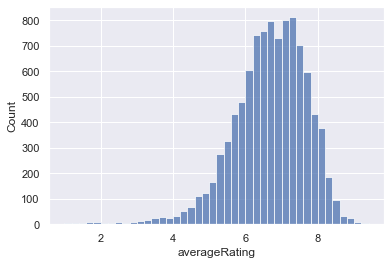

In [14]:
# How are the ratings distributed
sns.histplot(data=df_movies, x="averageRating", binwidth=0.20);

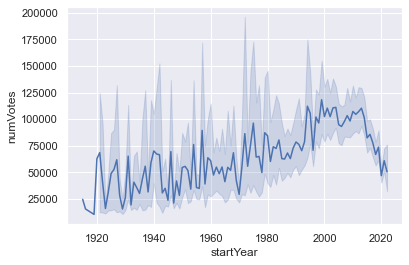

In [15]:
# Do newer movies receive more ratings ? 
sns.lineplot(data=df_movies, x="startYear", y="numVotes");

In [16]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
df_movies["genres"].apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

1613          Drama
1613        History
1613            War
2007          Drama
2007        History
             ...   
1245953      Comedy
1245953       Crime
1246062      Action
1246062       Crime
1246062    Thriller
Name: genres, Length: 25497, dtype: object

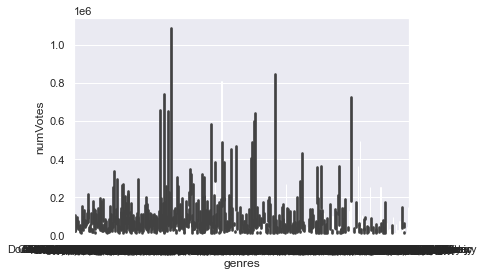

In [17]:
# What genres of movies receive more attention over time ?
# TODO: only keep n most relevant genres
# sns.barplot(data=df_movies.explode("genres"), x="genres", y="numVotes");

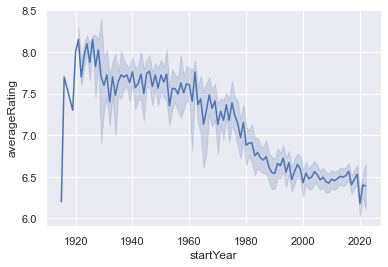

In [18]:
sns.lineplot(data=df_movies, x="startYear", y="averageRating");
# Important question: the increase of the average rating is due to real
# improvement of the movies or are we biased to give a better rating to
# what is more recent 

### Actors dataset

Here we are mostly interested in the actors, and eventually directors. The attribute "knownForTitle" will be used to link the actors together.

In [38]:
actors = pd.read_csv("data/name.basics.tsv.gz", sep="\t", compression="gzip", na_values = "\\N")
actors.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0053137,tt0072308,tt0031983,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0117057,tt0071877,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0057345,tt0054452,tt0056404,tt0049189"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0050976,tt0083922,tt0050986,tt0060827"


In [39]:
actors_df = actors[['nconst', 'primaryName', 'knownForTitles']]
actors_df

,nconst,primaryName,knownForTitles
0,nm0000001,Fred Astaire,"tt0053137,tt0072308,tt0031983,tt0050419"
1,nm0000002,Lauren Bacall,"tt0117057,tt0071877,tt0037382,tt0038355"
2,nm0000003,Brigitte Bardot,"tt0057345,tt0054452,tt0056404,tt0049189"
3,nm0000004,John Belushi,"tt0072562,tt0080455,tt0078723,tt0077975"
4,nm0000005,Ingmar Bergman,"tt0050976,tt0083922,tt0050986,tt0060827"
...,...,...,...
11649765,nm9993714,Romeo del Rosario,"tt14069590,tt11657662,tt2455546"
11649766,nm9993716,Essias Loberg,NaN
11649767,nm9993717,Harikrishnan Rajan,tt8736744
11649768,nm9993718,Aayush Nair,NaN


In [42]:
actors_df.dropna(inplace=True)
splitted_tconsts = actors_df["knownForTitles"].str.split(',')

In [47]:
def num_votes(t):
    try:
        return movies_df.loc[t]["numVotes"]
    except KeyError:
        return 0

numvotes_rows = splitted_tconsts.apply(lambda row: list(map(num_votes, row)))
actors_df["titlesNumVotes"] = numvotes_rows


In [ ]:
actors_df["titlesNumVotes"].sum()

In [48]:
actors_df.to_csv("data/actor_dataset.csv", index=False)

In [49]:
exploded_titles = actors.knownForTitles.apply(lambda s: s.split(',') if isinstance(s, str) else None).explode()

In [50]:
actors = actors.join(exploded_titles, rsuffix="_ex")

In [51]:
G_actors = nx.Graph()
G_actors.add_nodes_from(actors["primaryName"])

KeyboardInterrupt: 

In [ ]:
actors.groupby("knownForTitles_ex").primaryName.apply(lambda group: G_actors.add_edges_from(combinations(group, 2)));

Name: 
Type: Graph
Number of nodes: 4947
Number of edges: 22143
Average degree:   8.9521


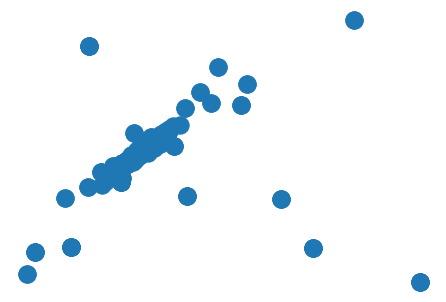

In [ ]:
print(nx.info(G_actors))
nx.draw_spectral(G_actors)
# adj_mat = nx.to_numpy_matrix(G_actors)

# spectral_clustering = SpectralClustering(10, affinity="precomputed").fit(adj_mat)